In [1]:
! pip install kneed

In [2]:
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
project_path= '/content/drive/MyDrive/P10- RAG-GAS/'

Mounted at /content/drive


In [4]:
import os
os.chdir(project_path)

In [5]:
# Read Data
data = pd.read_csv('data_eng.csv')
data_positive = data[data['Successful']]
data_negative = data[~data['Successful']]

In [7]:
! pip install faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [8]:
import faiss
from sentence_transformers import SentenceTransformer

class RetrievalSystem:

  def __init__(
      self,
      db : pd.DataFrame,
      embedding_model_name : str,
      lang = 'eng',
  ):
    # DB
    self.db = db
    self.db_positive = db[db['Successful']]
    self.db_negative = db[~db['Successful']]

    # Instantiate embedding model
    print(f"Instantiating embedding model: {embedding_model_name}")
    self.embedding_model_name = embedding_model_name
    self.embedding_model = SentenceTransformer(self.embedding_model_name,trust_remote_code=True)
    self._summary_name = "Summary" if lang == 'eng' else lang + "_Summary"

    self._set_up_semantic_search()

    print("System created.")

  def _set_up_semantic_search(self):
    # Set-up for semantic search
    self.pos_embeddings= {}
    self.neg_embeddings= {}
    self.embeddings= {}

    self.pos_index= {}
    self.neg_index= {}
    self.index= {}

    ## Generate embeddings
    print("Generating embeddings")
    ### Not Scaled
    self.pos_embeddings['not_scaled'] = self.embedding_model.encode(self.db_positive[self._summary_name].tolist())
    self.neg_embeddings['not_scaled'] = self.embedding_model.encode(self.db_negative[self._summary_name].tolist())
    self.embeddings['not_scaled'] = self.embedding_model.encode(self.db[self._summary_name].tolist())
    ### Scaled
    print("Scaling embeddigs...")
    self.pos_embeddings['scaled'] = self.pos_embeddings['not_scaled'].copy()
    self.neg_embeddings['scaled'] = self.neg_embeddings['not_scaled'].copy()
    self.embeddings['scaled'] = self.embeddings['not_scaled'].copy()
    faiss.normalize_L2(self.pos_embeddings['scaled'])
    faiss.normalize_L2(self.neg_embeddings['scaled'])
    faiss.normalize_L2(self.embeddings['scaled'])

    ## Instantiate FAISS indexes
    ### For IP
    self.pos_index['IP'] = faiss.IndexFlatIP(self.pos_embeddings['not_scaled'].shape[1])
    self.pos_index['IP'].add(self.pos_embeddings['not_scaled'])
    self.neg_index['IP'] = faiss.IndexFlatIP(self.neg_embeddings['not_scaled'].shape[1])
    self.neg_index['IP'].add(self.neg_embeddings['not_scaled'])
    self.index['IP'] = faiss.IndexFlatIP(self.embeddings['not_scaled'].shape[1])
    self.index['IP'].add(self.embeddings['not_scaled'])


    ### For Cosine similarity
    self.pos_index['COS'] = faiss.IndexFlatIP(self.pos_embeddings['scaled'].shape[1])
    self.pos_index['COS'].add(self.pos_embeddings['scaled'])
    self.neg_index['COS'] = faiss.IndexFlatIP(self.neg_embeddings['scaled'].shape[1])
    self.neg_index['COS'].add(self.neg_embeddings['scaled'])
    self.index['COS'] = faiss.IndexFlatIP(self.embeddings['scaled'].shape[1])
    self.index['COS'].add(self.embeddings['scaled'])

    ### For L2-not_scaled
    self.pos_index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.pos_embeddings['not_scaled'].shape[1])
    self.pos_index['L2-NOT-SCALED'].add(self.pos_embeddings['not_scaled'])
    self.neg_index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.neg_embeddings['not_scaled'].shape[1])
    self.neg_index['L2-NOT-SCALED'].add(self.neg_embeddings['not_scaled'])
    self.index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.embeddings['not_scaled'].shape[1])
    self.index['L2-NOT-SCALED'].add(self.embeddings['not_scaled'])

    ### For L2-scaled
    self.pos_index['L2-SCALED'] = faiss.IndexFlatL2(self.pos_embeddings['scaled'].shape[1])
    self.pos_index['L2-SCALED'].add(self.pos_embeddings['scaled'])
    self.neg_index['L2-SCALED'] = faiss.IndexFlatL2(self.neg_embeddings['scaled'].shape[1])
    self.neg_index['L2-SCALED'].add(self.neg_embeddings['scaled'])
    self.index['L2-SCALED'] = faiss.IndexFlatL2(self.embeddings['scaled'].shape[1])
    self.index['L2-SCALED'].add(self.embeddings['scaled'])


  @staticmethod
  def _filter_and_limit(similarity, indices, upper_bound, lower_bound):

      if upper_bound is not None:
          mask = similarity <= upper_bound
          similarity = similarity[mask]
          indices = indices[mask]

      if lower_bound is not None:
          mask = similarity >= lower_bound
          similarity = similarity[mask]
          indices = indices[mask]

      return similarity, indices

  def retrieve(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound : float = None,
        lower_bound : float = None,
        metric : str = 'IP'
  ) -> pd.DataFrame:
      """
      Retrieve examples from memory based on similarity to the query.
      Args:
          query (str): The query summary to retrieve examples for.
          top_k (int): The number of examples to retrieve.
          split (bool): Whether to separate positive and negative indices.
          upper_bound (float): maximum similarity score.
          lower_bound (float): minimum similarity score

      Returns:
          pd.DataFrame: A DataFrame of the retrieved examples with a 'distance' column.
      """
      query_embedding = self.embedding_model.encode([query])
      if metric in ['COS','L2-SCALED']:
        faiss.normalize_L2(query_embedding)

      if not split:
          metric_score, indices = self.index[metric].search(query_embedding, top_k)
          metric_score, indices = RetrievalSystem._filter_and_limit(metric_score[0], indices[0], upper_bound=upper_bound,lower_bound=lower_bound)
          retrieved_df = self.db.iloc[indices].copy()
          retrieved_df[metric] = metric_score

      else:
          metric_score_pos, indices_pos = self.pos_index[metric].search(query_embedding, top_k)
          metric_score_neg, indices_neg = self.neg_index[metric].search(query_embedding, top_k)

          metric_score_pos, indices_pos = RetrievalSystem._filter_and_limit(metric_score_pos[0], indices_pos[0], upper_bound=upper_bound,lower_bound=lower_bound)
          metric_score_neg, indices_neg = RetrievalSystem._filter_and_limit(metric_score_neg[0], indices_neg[0], upper_bound=upper_bound,lower_bound=lower_bound)

          pos_retrieved = self.db_positive.iloc[indices_pos].copy()
          pos_retrieved[metric] = metric_score_pos

          neg_retrieved = self.db_negative.iloc[indices_neg].copy()
          neg_retrieved[metric] = metric_score_neg

          retrieved_df = pd.concat([pos_retrieved, neg_retrieved])

      return retrieved_df.sort_values(by=metric, ascending = True if 'L2' in metric else False)

  def __call__(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound : float = None,
        lower_bound : float = None,
        metric : str = 'IP'
  ) -> pd.DataFrame:
      return self.retrieve(query,top_k,split,upper_bound,lower_bound,metric)

In [ ]:
best_encoder_name = 'bert-base-nli-mean-tokens'
encoder = RetrievalSystem(db = data, embedding_model_name = best_encoder_name)

Instantiating embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
# Funzione per plottare le distribuzioni KDE per alcuni k
def plot_distributions(distances_dict, selected_k, title="Distribuzione delle distanze negative per vari k"):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("viridis", n_colors=len(selected_k))

    for i, k in enumerate(selected_k):
        if k not in distances_dict:
            print(f"Attenzione: k={k} non presente nei dati.")
            continue
        sns.kdeplot(distances_dict[k], label=f"k = {k}", linewidth=2, color=palette[i])

    plt.title(title)
    plt.xlabel("r^2")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_histograms(distances_dict, selected_k, bins=30, title="Distribuzione delle distanze negative (istogrammi)"):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("viridis", n_colors=len(selected_k))

    for i, k in enumerate(selected_k):
        if k not in distances_dict:
            print(f"Attenzione: k={k} non presente nei dati.")
            continue
        plt.hist(
            distances_dict[k],
            bins=bins,
            alpha=0.5,
            label=f"k = {k}",
            color=palette[i],
            density=True  # per rendere confrontabili le distribuzioni
        )

    plt.title(title)
    plt.xlabel("Distanza (L2 - Non Scalato)")
    plt.ylabel("Densità normalizzata")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Mediana come metrica rappresentativa del singolo  cluster $\mathcal{N}_{(+),k}^{*,{-}}$

Semplicemente usiamo la mediana al posto della media. La formalizzazione sembra complicata giusto per come è definita la media.

## 1) Calcolo del candidato per ciascun valore di k
### 1.A) Calcolo interno a ciascun cluster ${\mathcal{N}}_{(+),k}^{*,{-}}$
Dato un valore k $\in \mathbb{N}$, $\ ∀ (+) \in M_+$:
$$\mathcal{R}(k,(+)) = \{|| e_{(+)} - e_{(-)} \|_2 : (-) \in \mathcal{N}_{(+)_i,k}^{*,{-}}\}$$
E' l'insieme delle distanze dai k punti (-) più vicini a (+).
Utilizziamo la funzione quantile per formalizzare il calcolo della mediana:
$$ r_{median}(k,(+))
= \inf\!\left\{ r : \frac{\bigl|\{\,d \in \mathcal{R}(k,(+)) : d \le r\}\bigr|}{k} \ge 0.5 \right\}$$

### 1.B) Aggregazione su tutti i punti positivi nel dataset.
Per trovare il **candidato k** a raggio di esplosione $r_{EXP}(k)$, dobbiamo aggregare su tutti i punti positivi:

*   Utilizzando la media come misura di aggregazione sugli elementi positivi nel dataset:
$$r_{EXPL}(k) = \frac{1}{|M_+|} \sum_{(+) \in M_+}r_{median}(k,(+))$$

*   Utilizzando un quantile sulla distribuzione delle mediane :
$$
r_{EXPL}(k,u) =
inf\left\{
  r : \frac{|{(+) \in M_+ : r_{median}(k,(+)) ≤ r}|}{|M_+|} ≤ u
\right\}
$$


## 2) Calcolo del raggio di esplosione

Nell'idea di Federico di eliminare i punti a seconda di k, ci fermiamo al calcolo di $r_{EXP}(k)$:


*   k=1: applichiamo EXPL[+] con raggio r(1)
*   k=2: applichiamo EXPL[+] con raggio r(2)
*  ...
*   k=i: applichiamo EXPL[+] con raggio r(i)


Invece, se vogliamo stare con l'idea originale, quindi trovare il punto di ginocchio, scelto un numero massimo di punti da considerare K, si va a scegliere il punto di ginocchio da:
$$r_{elbow} \in \{r_{EXPL}(k) : k \le K\}$$



In [ ]:
from tqdm import tqdm
import seaborn as sns

kth_average_distances = {}

for k in tqdm(range(1, 50)):
    kth_dists = []

    for q in data_positive['Summary']:
        # Recupera i primi k vicini (positivi e negativi separati)
        neighborhood = encoder(
            q,
            top_k=k,
            upper_bound=None,
            lower_bound=None,
            metric='L2-NOT-SCALED',
            split=True
        )

        # Prendi solo i negativi
        neighborhood_neg = neighborhood[~neighborhood['Successful']]

        # Per ogni punto, calcola la distanza mediana nel cluster composto solo da negativi
        kth_dists.append(neighborhood_neg['L2-NOT-SCALED'].median())

    kth_average_distances[k] = kth_dists

100%|██████████| 49/49 [02:00<00:00,  2.45s/it]


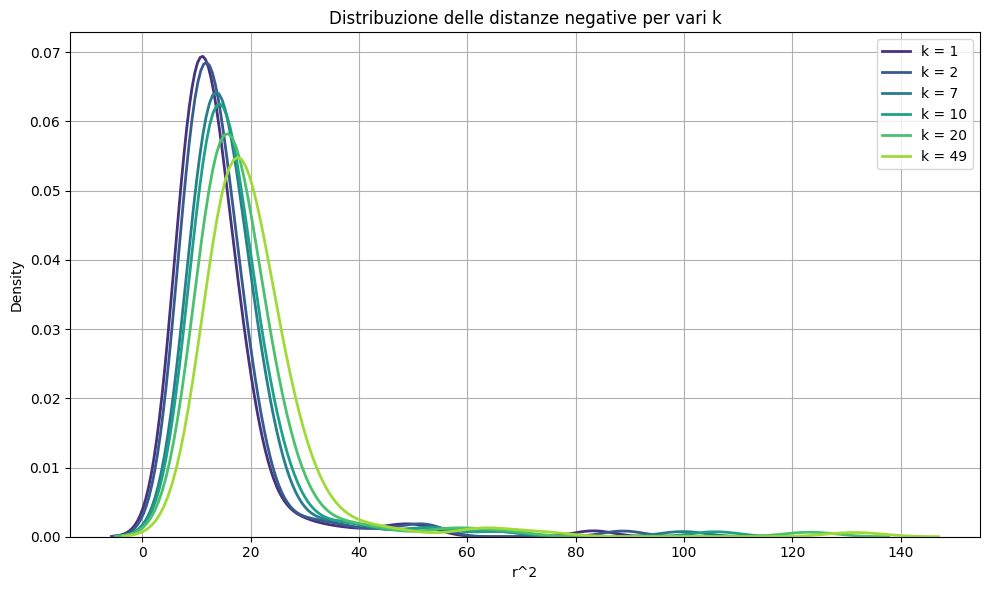

In [ ]:
plot_distributions(kth_average_distances, selected_k=[1, 2, 7, 10, 20, 49])

In [ ]:
# Creazione della tabella con statistiche per ciascun k
import numpy as np
stats = []

for k, dists in kth_average_distances.items():
    if len(dists) == 0:
        continue  # Evita entry vuote
    stats.append({
        'k': k,
        'mean': np.mean(dists),
        'variance': np.var(dists),
        'q25': np.percentile(dists, 25),
        'q50': np.percentile(dists, 50),
        'q75': np.percentile(dists, 75)
    })

stats_df = pd.DataFrame(stats).sort_values(by='k').reset_index(drop=True).set_index('k')

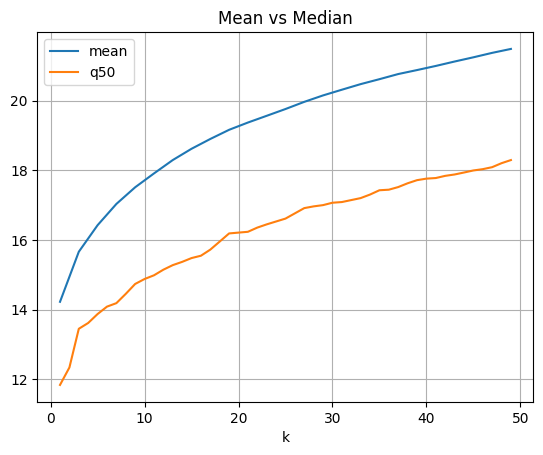

In [ ]:
stats_df[['mean', 'q50']].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

In [ ]:
! pip install kneed

In [ ]:
from kneed import KneeLocator

knee_points = {}

for feature in ['mean', 'variance', 'q25', 'q50', 'q75']:
    y = stats_df[feature].values
    x = stats_df.index.values

    # Curvatura della funzione: normalmente convessa per distanze
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    knee_points[feature] = kneedle.knee  # può essere None se non trovato

data = []
for feature, k in knee_points.items():
    if k is not None and k in stats_df.index:
        value_at_k = stats_df.loc[k, feature]
    else:
        value_at_k = None
    data.append({'feature': feature, 'k': k, 'value_at_k': value_at_k})

knee_df = pd.DataFrame(data).set_index('feature')
knee_df


,k,value_at_k
feature,,
mean,15,18.615361
variance,15,154.844530
q25,15,13.028023
q50,12,15.145680
q75,16,20.145380


# Media come distanza rappresentativa del singolo cluster $r_{EXPL}$ $\mathcal{N}_{(+),k}^{*,{-}}$

Le parti 1.B e 2 restano invariate. Cambiamo solo la metrica rappresentativa della distanza dei singolo cluster, 1.A.

In poche parole, al posto di calcolare la mediana del cluster $\mathcal{N}_{(+),k}^{*,{-}}$, **ne calcoliamo la media, come abbiamo sempre fatto fino ad adesso**

$$r_{mean}(k,(+)) = \frac{\sum_{n \in \mathcal{N}_{p,k}^{*,-}} \| e_p - e_n \|_2}{k}$$

La formula sul paper è anche quella "sbagliata": considera la distanza totale e non la distanza media. Il calcolo che facevo era quello descritto dalla formula qui invece!

Si può riscrivere meglio in:

$$r(k) = \frac{ \sum_{p \in M_+} \sum_{n \in \mathcal{N}_{p,k}^{*,-}} \| e_p - e_n \|_2}{k|M_+|}$$

## 0<k<500

In [ ]:
from tqdm import tqdm
import seaborn as sns

kth_average_distances = {}

for k in tqdm(range(1, 500)):
    kth_dists = []

    for q in data_positive['Summary']:
        # Recupera i primi k vicini (positivi e negativi separati)
        neighborhood = encoder(
            q,
            top_k=k,
            upper_bound=None,
            lower_bound=None,
            metric='L2-NOT-SCALED',
            split=True
        )

        # Prendi solo i negativi
        neighborhood_neg = neighborhood[~neighborhood['Successful']]

        # Per ogni punto, calcola la distanza media nel cluster avente k elementi negativi
        kth_dists.append(neighborhood_neg['L2-NOT-SCALED'].mean())

    kth_average_distances[k] = kth_dists

100%|██████████| 499/499 [20:06<00:00,  2.42s/it]


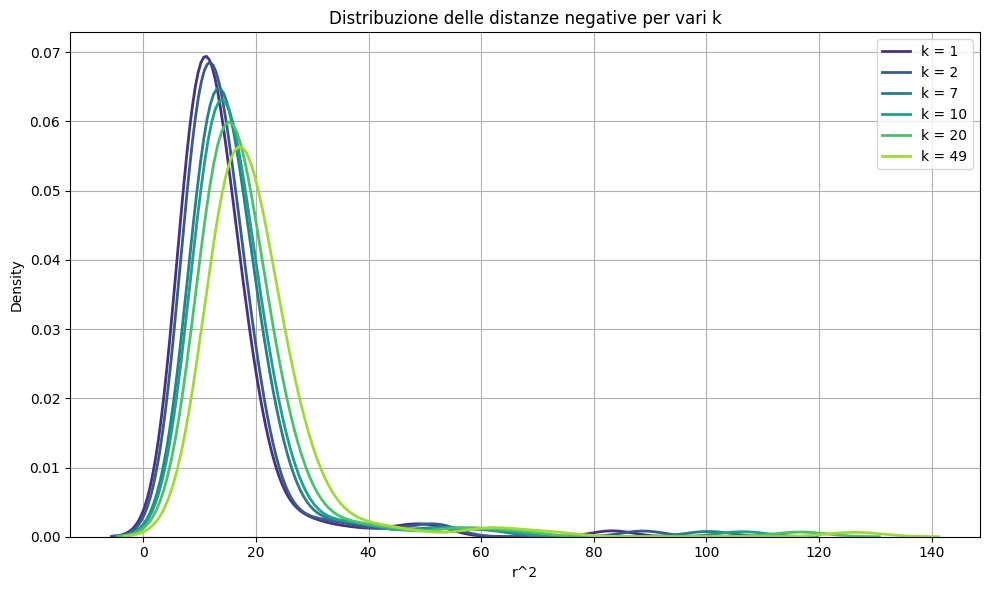

In [ ]:
plot_distributions(kth_average_distances, selected_k=[1, 2, 7, 10, 20, 49])

In [ ]:
# Creazione della tabella con statistiche per ciascun k
import numpy as np
stats = []

for k, dists in kth_average_distances.items():
    if len(dists) == 0:
        continue  # Evita entry vuote
    stats.append({
        'k': k,
        'mean': np.mean(dists),
        'variance': np.var(dists),
        'q25': np.percentile(dists, 25),
        'q50': np.percentile(dists, 50),
        'q75': np.percentile(dists, 75)
    })

stats_df = pd.DataFrame(stats).sort_values(by='k').reset_index(drop=True).set_index('k')

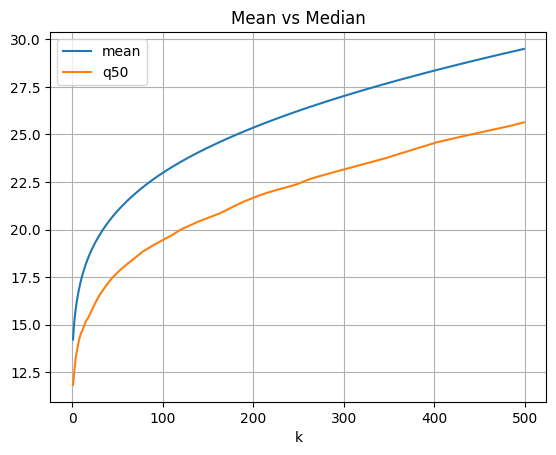

In [ ]:
stats_df[['mean', 'q50']].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

In [ ]:
! pip install kneed

In [ ]:
from kneed import KneeLocator

knee_points = {}

for feature in ['mean', 'variance', 'q25', 'q50', 'q75']:
    y = stats_df[feature].values
    x = stats_df.index.values

    # Curvatura della funzione: normalmente convessa per distanze
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    knee_points[feature] = kneedle.knee  # può essere None se non trovato

data = []
for feature, k in knee_points.items():
    if k is not None and k in stats_df.index:
        value_at_k = stats_df.loc[k, feature]
    else:
        value_at_k = None
    data.append({'feature': feature, 'k': k, 'value_at_k': value_at_k})

knee_df = pd.DataFrame(data).set_index('feature')
knee_df


,k,value_at_k
feature,,
mean,102,23.039598
variance,84,183.515869
q25,102,16.797638
q50,90,19.186453
q75,81,23.985641


## 0<k<100

In [ ]:
from tqdm import tqdm
import seaborn as sns

kth_average_distances = {}

for k in tqdm(range(1, 100)):
    kth_dists = []

    for q in data_positive['Summary']:
        # Recupera i primi k vicini (positivi e negativi separati)
        neighborhood = encoder(
            q,
            top_k=k,
            upper_bound=None,
            lower_bound=None,
            metric='L2-NOT-SCALED',
            split=True
        )

        # Prendi solo i negativi
        neighborhood_neg = neighborhood[~neighborhood['Successful']]

        # Per ogni punto, calcola la distanza media nel cluster avente k elementi negativi
        kth_dists.append(neighborhood_neg['L2-NOT-SCALED'].mean())

    kth_average_distances[k] = kth_dists

100%|██████████| 99/99 [04:27<00:00,  2.70s/it]


Attenzione: k=100 non presente nei dati.


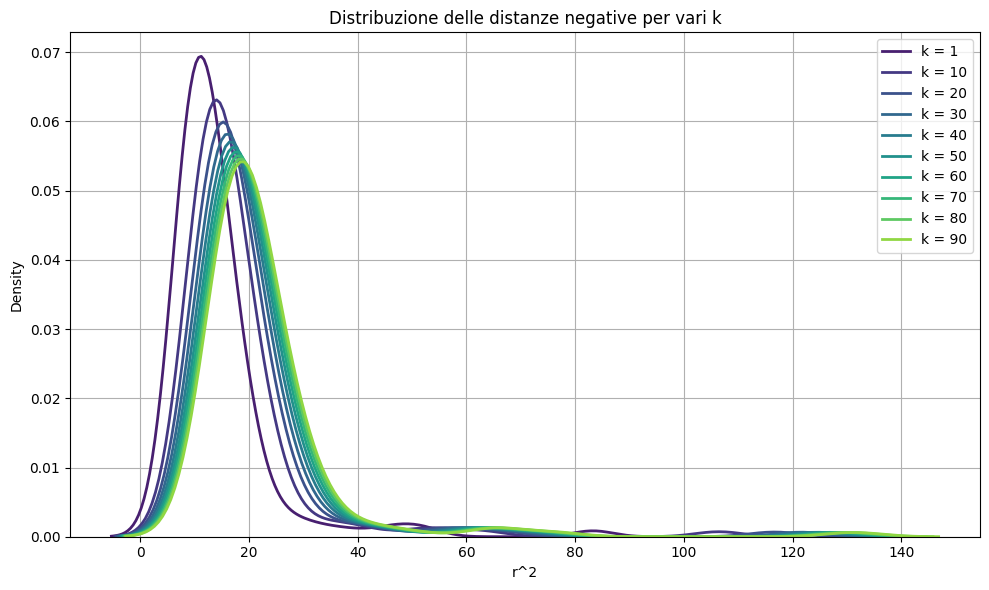

In [ ]:
plot_distributions(kth_average_distances, selected_k=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [ ]:
# Creazione della tabella con statistiche per ciascun k
import numpy as np
stats = []

for k, dists in kth_average_distances.items():
    if len(dists) == 0:
        continue  # Evita entry vuote
    stats.append({
        'k': k,
        'mean': np.mean(dists),
        'variance': np.var(dists),
        'q25': np.percentile(dists, 25),
        'q50': np.percentile(dists, 50),
        'q75': np.percentile(dists, 75)
    })

stats_df = pd.DataFrame(stats).sort_values(by='k').reset_index(drop=True).set_index('k')

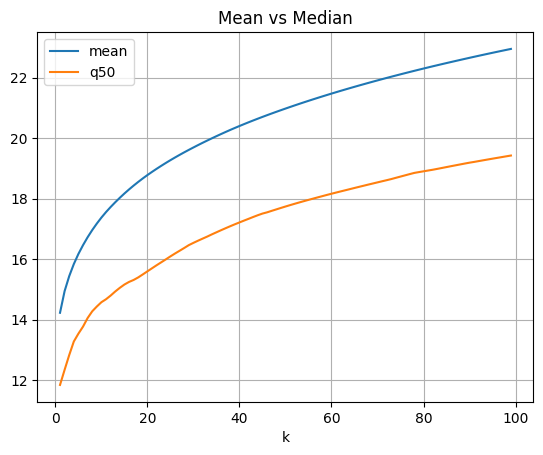

In [ ]:
stats_df[['mean', 'q50']].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

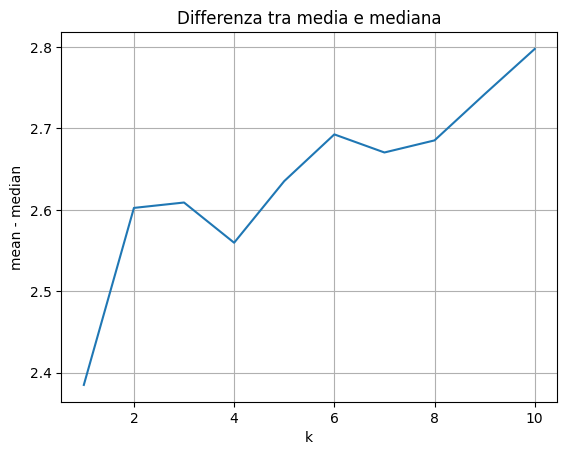

In [ ]:
(stats_df['mean'] - stats_df['q50']).iloc[:10].plot(title='Differenza tra media e mediana')
plt.ylabel('mean - median')
plt.xlabel('k')
plt.grid(True)
plt.show()

In [ ]:
from kneed import KneeLocator

knee_points = {}

for feature in ['mean', 'variance', 'q25', 'q50', 'q75']:
    y = stats_df[feature].values
    x = stats_df.index.values

    # Curvatura della funzione: normalmente convessa per distanze
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    knee_points[feature] = kneedle.knee  # può essere None se non trovato

data = []
for feature, k in knee_points.items():
    if k is not None and k in stats_df.index:
        value_at_k = stats_df.loc[k, feature]
    else:
        value_at_k = None
    data.append({'feature': feature, 'k': k, 'value_at_k': value_at_k})

knee_df = pd.DataFrame(data).set_index('feature')
knee_df


,k,value_at_k
feature,,
mean,25,19.269453
variance,27,158.479095
q25,29,13.796735
q50,29,16.461601
q75,36,21.724354


## 0<k<50

In [ ]:
from tqdm import tqdm
import seaborn as sns

kth_average_distances = {}

for k in tqdm(range(1, 50)):
    kth_dists = []

    for q in data_positive['Summary']:
        # Recupera i primi k vicini (positivi e negativi separati)
        neighborhood = encoder(
            q,
            top_k=k,
            upper_bound=None,
            lower_bound=None,
            metric='L2-NOT-SCALED',
            split=True
        )

        # Prendi solo i negativi
        neighborhood_neg = neighborhood[~neighborhood['Successful']]

        # Per ogni punto, calcola la distanza media nel cluster avente k elementi negativi
        kth_dists.append(neighborhood_neg['L2-NOT-SCALED'].mean())

    kth_average_distances[k] = kth_dists

100%|██████████| 49/49 [01:58<00:00,  2.41s/it]


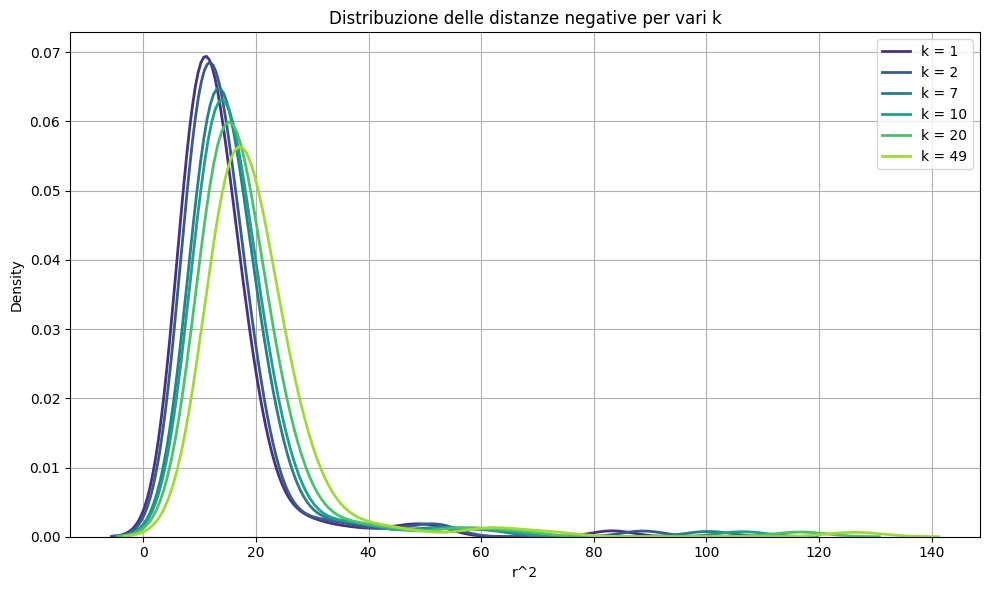

In [ ]:
plot_distributions(kth_average_distances, selected_k=[1, 2, 7, 10, 20, 49])

In [ ]:
# Creazione della tabella con statistiche per ciascun k
import numpy as np
stats = []

for k, dists in kth_average_distances.items():
    if len(dists) == 0:
        continue  # Evita entry vuote
    stats.append({
        'k': k,
        'mean': np.mean(dists),
        'variance': np.var(dists),
        'q25': np.percentile(dists, 25),
        'q50': np.percentile(dists, 50),
        'q75': np.percentile(dists, 75)
    })

stats_df = pd.DataFrame(stats).sort_values(by='k').reset_index(drop=True).set_index('k')

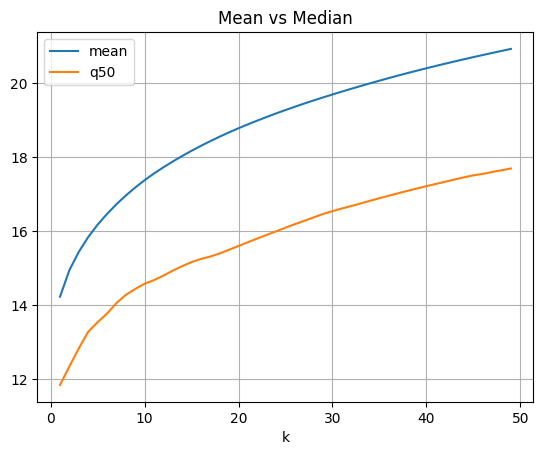

In [ ]:
stats_df[['mean', 'q50']].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

In [ ]:
! pip install kneed

In [ ]:
from kneed import KneeLocator

knee_points = {}

for feature in ['mean', 'variance', 'q25', 'q50', 'q75']:
    y = stats_df[feature].values
    x = stats_df.index.values

    # Curvatura della funzione: normalmente convessa per distanze
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    knee_points[feature] = kneedle.knee  # può essere None se non trovato

data = []
for feature, k in knee_points.items():
    if k is not None and k in stats_df.index:
        value_at_k = stats_df.loc[k, feature]
    else:
        value_at_k = None
    data.append({'feature': feature, 'k': k, 'value_at_k': value_at_k})

knee_df = pd.DataFrame(data).set_index('feature')
knee_df


,k,value_at_k
feature,,
mean,15,18.167660
variance,16,145.237350
q25,16,12.655024
q50,13,14.928301
q75,20,19.932415


In [ ]:
knee_points.values()

dict_values([np.int64(14), np.int64(14), np.int64(16), np.int64(14), np.int64(9)])

In [ ]:
knee_df = pd.DataFrame(knee_points).T
knee_df.columns = ['knee_k', 'knee_value']
knee_df

,knee_k,knee_value
mean,49.0,23.523071
variance,49.0,194.634644
q25,49.0,17.046785
q50,49.0,19.989237
q75,49.0,24.913954


## 0<k<20

In [ ]:
from tqdm import tqdm
import seaborn as sns

kth_average_distances = {}

for k in tqdm(range(1, 20)):
    kth_dists = []

    for q in data_positive['Summary']:
        # Recupera i primi k vicini (positivi e negativi separati)
        neighborhood = encoder(
            q,
            top_k=k,
            upper_bound=None,
            lower_bound=None,
            metric='L2-NOT-SCALED',
            split=True
        )

        # Prendi solo i negativi
        neighborhood_neg = neighborhood[~neighborhood['Successful']]

        # Per ogni punto, calcola la distanza media nel cluster avente k elementi negativi
        kth_dists.append(neighborhood_neg['L2-NOT-SCALED'].mean())

    kth_average_distances[k] = kth_dists

100%|██████████| 19/19 [00:46<00:00,  2.44s/it]


Attenzione: k=20 non presente nei dati.
Attenzione: k=49 non presente nei dati.


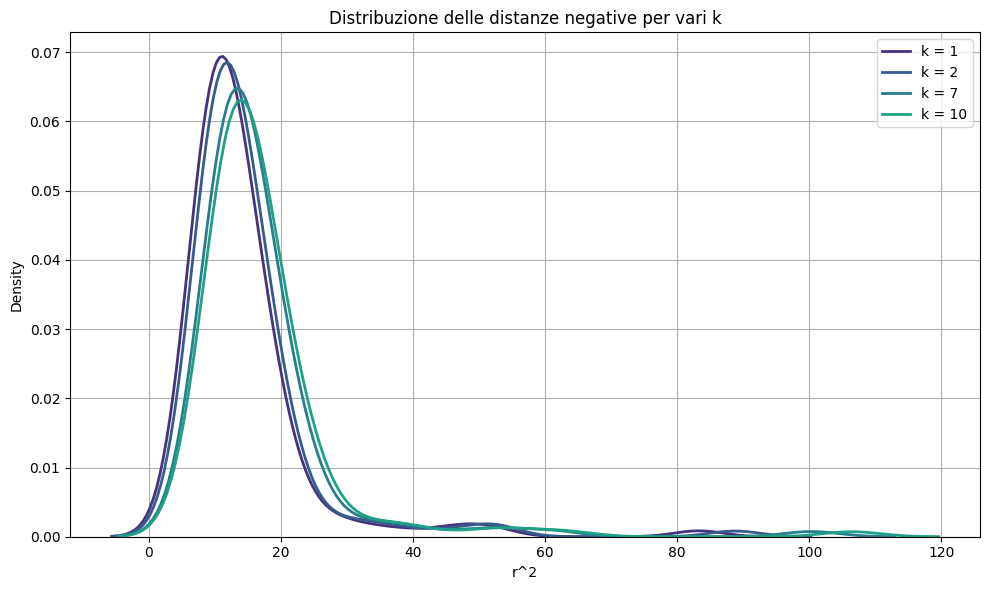

In [ ]:
plot_distributions(kth_average_distances, selected_k=[1, 2, 7, 10, 20, 49])

In [ ]:
# Creazione della tabella con statistiche per ciascun k
import numpy as np
stats = []

for k, dists in kth_average_distances.items():
    if len(dists) == 0:
        continue  # Evita entry vuote
    stats.append({
        'k': k,
        'mean': np.mean(dists),
        'variance': np.var(dists),
        'q25': np.percentile(dists, 25),
        'q50': np.percentile(dists, 50),
        'q75': np.percentile(dists, 75)
    })

stats_df = pd.DataFrame(stats).sort_values(by='k').reset_index(drop=True).set_index('k')

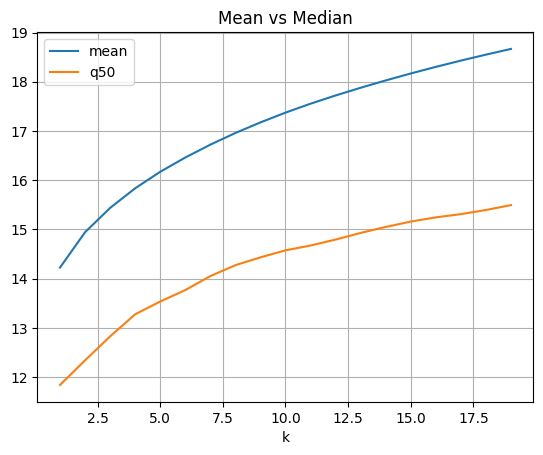

In [ ]:
stats_df[['mean', 'q50']].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

In [ ]:
from kneed import KneeLocator

knee_points = {}

for feature in ['mean', 'variance', 'q25', 'q50', 'q75']:
    y = stats_df[feature].values
    x = stats_df.index.values

    # Curvatura della funzione: normalmente convessa per distanze
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    knee_points[feature] = kneedle.knee  # può essere None se non trovato

data = []
for feature, k in knee_points.items():
    if k is not None and k in stats_df.index:
        value_at_k = stats_df.loc[k, feature]
    else:
        value_at_k = None
    data.append({'feature': feature, 'k': k, 'value_at_k': value_at_k})

knee_df = pd.DataFrame(data).set_index('feature')
knee_df


,k,value_at_k
feature,,
mean,7,16.721502
variance,9,129.058319
q25,6,11.316532
q50,8,14.272914
q75,9,18.495459


# Distanza dal k-esimo elemento.
Anche qui, 1.B e 2 invariate, cambiamo solo 1.A

Invece di utilizzare la distanza media, consideriamo, dato k, la distanza tra (+) e il k-esimo elemento (-) più vicino:

$$\mathcal{R}(k,(+)) = \{|| e_{(+)} - e_{(-)} \|_2 : (-) \in \mathcal{N}_{(+)_i,k}^{*,{-}}\}$$
$$r_{max}(k,(+)) = max\{\mathcal{R}(k,(+))\}$$

In [ ]:

from tqdm import tqdm
import seaborn as sns

kth_distances = {}

for k in tqdm(range(1, 50)):
    kth_dists = []

    for q in data_positive['Summary']:
        # Recupera i primi k vicini (positivi e negativi separati)
        neighborhood = encoder(
            q,
            top_k=k,
            upper_bound=None,
            lower_bound=None,
            metric='L2-NOT-SCALED',
            split=True
        )

        # Prendi solo i negativi
        neighborhood_neg = neighborhood[~neighborhood['Successful']]

        # Se ci sono almeno k negativi, prendi il k-esimo
        if len(neighborhood_neg) >= k:
            kth_distance = neighborhood_neg.iloc[k - 1]['L2-NOT-SCALED']
            kth_dists.append(kth_distance)
        else:
            # Se meno di k negativi, ignora o metti NaN
            kth_dists.append(np.nan)

    kth_distances[k] = kth_dists

100%|██████████| 49/49 [02:01<00:00,  2.47s/it]


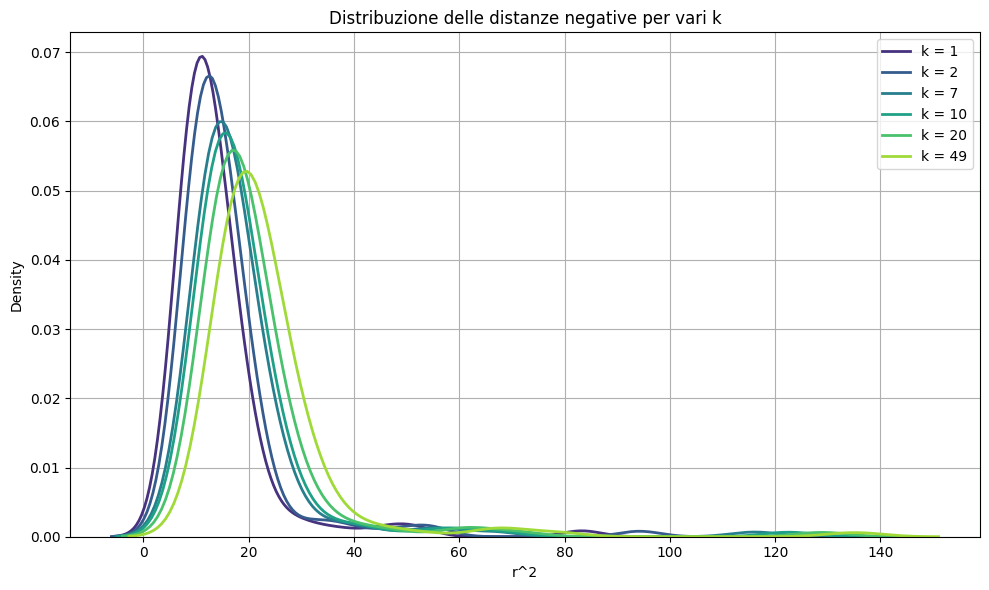

In [ ]:
plot_distributions(kth_distances, selected_k=[1, 2, 7, 10, 20, 49])

In [ ]:
# Creazione della tabella con statistiche per ciascun k
import numpy as np
stats = []

for k, dists in kth_distances.items():
    if len(dists) == 0:
        continue  # Evita entry vuote
    stats.append({
        'k': k,
        'mean': np.mean(dists),
        'variance': np.var(dists),
        'q25': np.percentile(dists, 25),
        'q50': np.percentile(dists, 50),
        'q75': np.percentile(dists, 75)
    })

stats_df = pd.DataFrame(stats).sort_values(by='k').reset_index(drop=True).set_index('k')

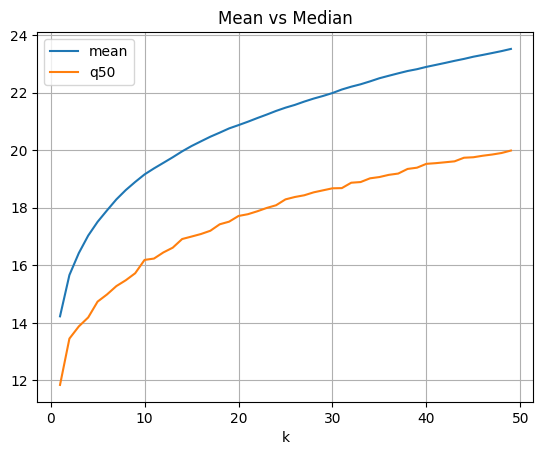

In [ ]:
# Plot media e mediana insieme
stats_df[['mean', 'q50']].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

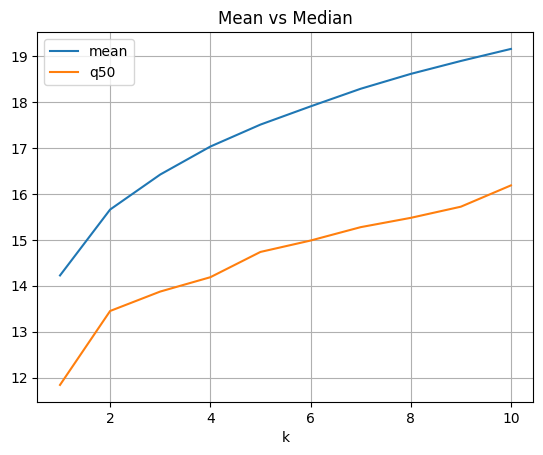

In [ ]:
# Zoom
stats_df[['mean', 'q50']].iloc[:10].plot(title='Mean vs Median')
plt.xlabel("k")
plt.grid(True)
plt.show()

In [ ]:
from kneed import KneeLocator

knee_points = {}

for feature in ['mean', 'variance', 'q25', 'q50', 'q75']:
    y = stats_df[feature].values
    x = stats_df.index.values

    # Curvatura della funzione: normalmente convessa per distanze
    kneedle = KneeLocator(x, y, curve='concave', direction='increasing')

    knee_points[feature] = kneedle.knee  # può essere None se non trovato

data = []
for feature, k in knee_points.items():
    if k is not None and k in stats_df.index:
        value_at_k = stats_df.loc[k, feature]
    else:
        value_at_k = None
    data.append({'feature': feature, 'k': k, 'value_at_k': value_at_k})

knee_df = pd.DataFrame(data).set_index('feature')
knee_df


           k  value_at_k
feature                 
mean      14   19.961454
variance  14  171.797974
q25       16   14.478638
q50       14   16.912617
q75        9   20.245508


In [ ]:
knee_points.values()

dict_values([np.int64(14), np.int64(14), np.int64(16), np.int64(14), np.int64(9)])

In [ ]:
knee_df = pd.DataFrame(knee_points).T
knee_df.columns = ['knee_k', 'knee_value']
knee_df

,knee_k,knee_value
mean,49.0,23.523071
variance,49.0,194.634644
q25,49.0,17.046785
q50,49.0,19.989237
q75,49.0,24.913954


# Cross-Validation
Stratifichiamo il dataset in nfold. Ovviamente in maniere "statificata", quindi facendo si che le propozioni (+)/(-) rimangano inalterate!

Le modalità sono

*   mean: che utilizza la media in 1.A
*   median: che utilizza la mediana in 1.A

Entrambe le modalità possono essere osservate usando per 1.B media, q25, q50 (median), q75



In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from kneed import KneeLocator
from tqdm import tqdm

def run_knee_cv(
    data: pd.DataFrame,
    encoder_name: str,
    summary_col: str = 'Summary',
    max_k: int = 50,
    nfolds: int = 5,
    aggregation: str = 'median'  # 'mean' or 'median'
):
    assert aggregation in ['mean', 'median'], "aggregation must be 'mean' or 'median'"

    results = []
    fold_stats_mean = {}   # k -> list of values per fold
    fold_stats_median = {}

    skf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(data, data['Successful'])):
        print(f"\n--- Fold {fold_idx + 1} ---")

        train_data = data.iloc[train_idx].reset_index(drop=True)
        val_data   = data.iloc[val_idx].reset_index(drop=True)

        val_counts = val_data['Successful'].value_counts()
        total = len(val_data)
        for label in [True, False]:
            count = val_counts.get(label, 0)
            print(f"{'Positivi' if label else 'Negativi'}: {count} ({count / total:.2%})")

        encoder = RetrievalSystem(db=train_data, embedding_model_name=encoder_name)
        kth_average_distances = {}

        for k in tqdm(range(1, max_k + 1), desc=f"Fold {fold_idx + 1}"):
            kth_dists = []

            for q in val_data[val_data['Successful']][summary_col]:
                neighborhood = encoder(
                    q,
                    top_k=k,
                    upper_bound=None,
                    lower_bound=None,
                    metric='L2-NOT-SCALED',
                    split=True
                )
                neg = neighborhood[~neighborhood['Successful']]
                if not neg.empty:
                    val_k = (
                        neg['L2-NOT-SCALED'].mean()
                        if aggregation == 'mean'
                        else neg['L2-NOT-SCALED'].median()
                    )
                    kth_dists.append(val_k)

            kth_average_distances[k] = kth_dists

        # Salva per plotting
        for k, dists in kth_average_distances.items():
            if len(dists) == 0:
                continue
            fold_stats_mean.setdefault(k, []).append(np.mean(dists))
            fold_stats_median.setdefault(k, []).append(np.median(dists))

        # Compute statistics and find knees
        for feature in ['mean','q25', 'q50', 'q75']:
            stats = []
            for k, dists in kth_average_distances.items():
                if len(dists) == 0:
                    continue
                stats.append({
                    'k': k,
                    'value': {
                        'mean': np.mean(dists),
                        'variance': np.var(dists),
                        'q25': np.percentile(dists, 25),
                        'q50': np.percentile(dists, 50),
                        'q75': np.percentile(dists, 75)
                    }[feature]
                })
            stats_df = pd.DataFrame(stats).set_index('k').sort_index()

            y = stats_df['value'].values
            x = stats_df.index.values
            kneedle = KneeLocator(x, y, curve='concave', direction='increasing')
            knee_k = kneedle.knee
            if knee_k not in stats_df.index:
              print(f"ERRORE nel folder {fold_idx} per la feature {feature}: {knee_k = }")
              print(f"{x =}")
              print(f"{y =}")
            knee_val = stats_df.loc[knee_k, 'value'] if knee_k in stats_df.index else None

            results.append({
                'fold': fold_idx + 1,
                'feature': feature,
                'knee_k': knee_k,
                'knee_value': knee_val
            })

    # Plotting se abilitato
    def plot_stat(stat_dict, stat_name):
        plt.figure(figsize=(10, 6))
        all_ks = sorted(stat_dict.keys())
        color_cycle = plt.cm.tab10.colors
        for fold_idx in range(nfolds):
            values = [stat_dict[k][fold_idx] for k in all_ks]
            plt.plot(all_ks, values, label=f'Fold {fold_idx + 1}', color=color_cycle[fold_idx % len(color_cycle)])
        # Linea media
        mean_values = [np.mean(stat_dict[k]) for k in all_ks]
        plt.plot(all_ks, mean_values, linestyle='--', color='black', label='Media')
        plt.title(f'{stat_name} per Fold')
        plt.xlabel('k')
        plt.ylabel(stat_name)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_stat(fold_stats_mean, 'Mean')
    plot_stat(fold_stats_median, 'Median')

    # Return table of knee results
    knee_df = pd.DataFrame(results)
    knee_k_df     = knee_df.pivot(index='feature', columns='fold', values='knee_k')
    knee_value_df = knee_df.pivot(index='feature', columns='fold', values='knee_value')

    return knee_k_df, knee_value_df


In [23]:
data = data = pd.read_csv('data_eng.csv')

## K=10


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


ERRORE nel folder 0 per la feature q50: knee_k = None
x =array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
y =array([11.2967   , 11.877759 , 12.04482  , 12.175787 , 12.3591175,
       12.575874 , 12.784959 , 12.951825 , 13.083829 , 13.225708 ],
      dtype=float32)

--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


ERRORE nel folder 3 per la feature q75: knee_k = None
x =array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
y =array([16.449753, 16.7757  , 17.419106, 17.648022, 17.89    , 18.237238,
       18.535656, 18.829851, 19.073553, 19.271702], dtype=float32)

--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


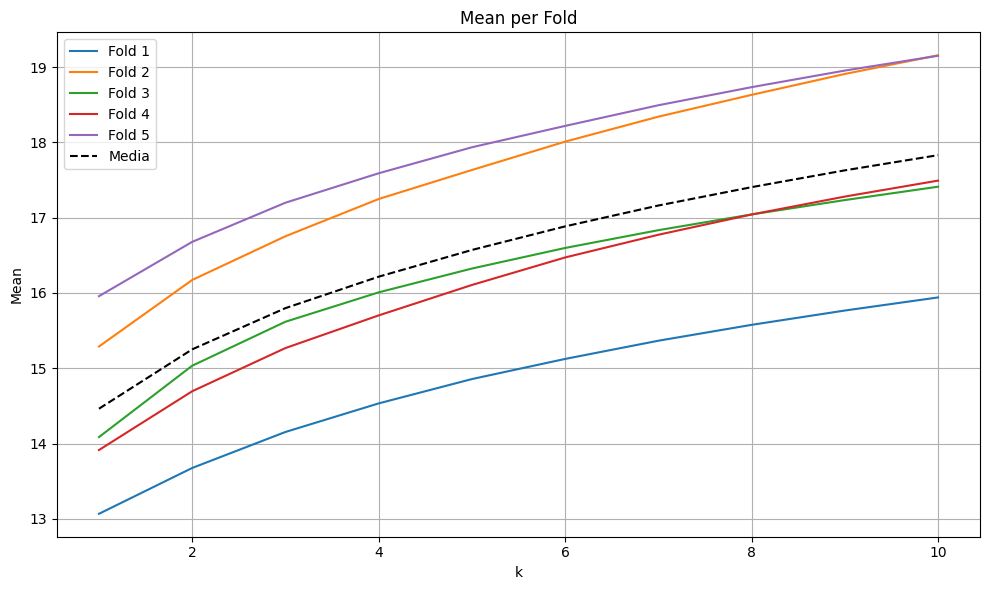

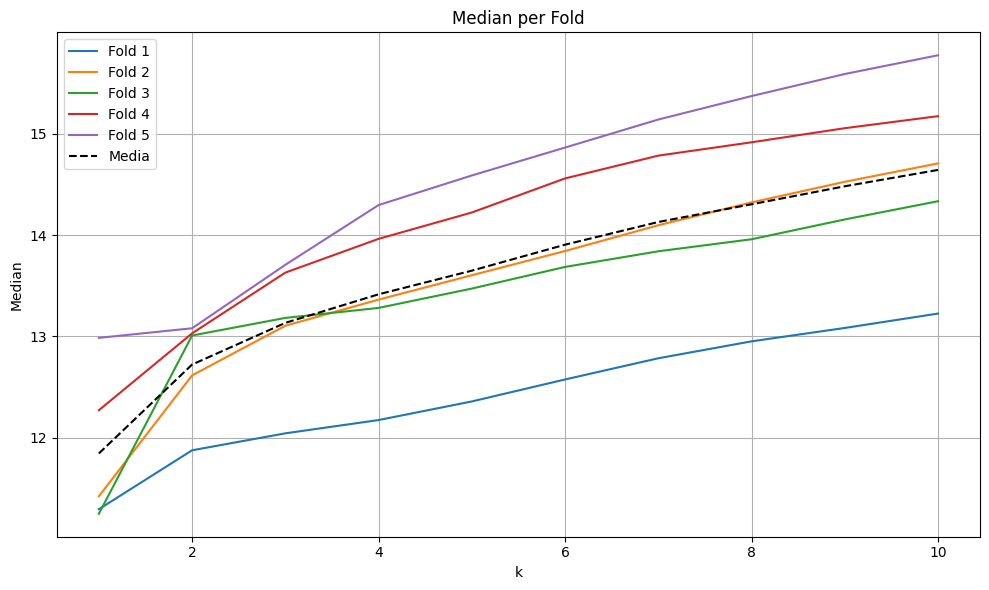

fold,1,2,3,4,5
feature,,,,,
mean,14.856823,17.247469,16.008150,16.106087,17.589090
q25,10.643085,11.546240,10.112172,11.700315,11.989321
q50,NaN,13.105855,13.009253,14.558239,14.295610
q75,16.645145,15.846912,15.962082,NaN,17.925484


In [27]:
################################################## MEAN
knee_k10_mean_point, knee_k10_mean_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=10,
    nfolds=5,
    aggregation='mean'
)
knee_k10_mean_values

## K=20


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]



--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]



--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


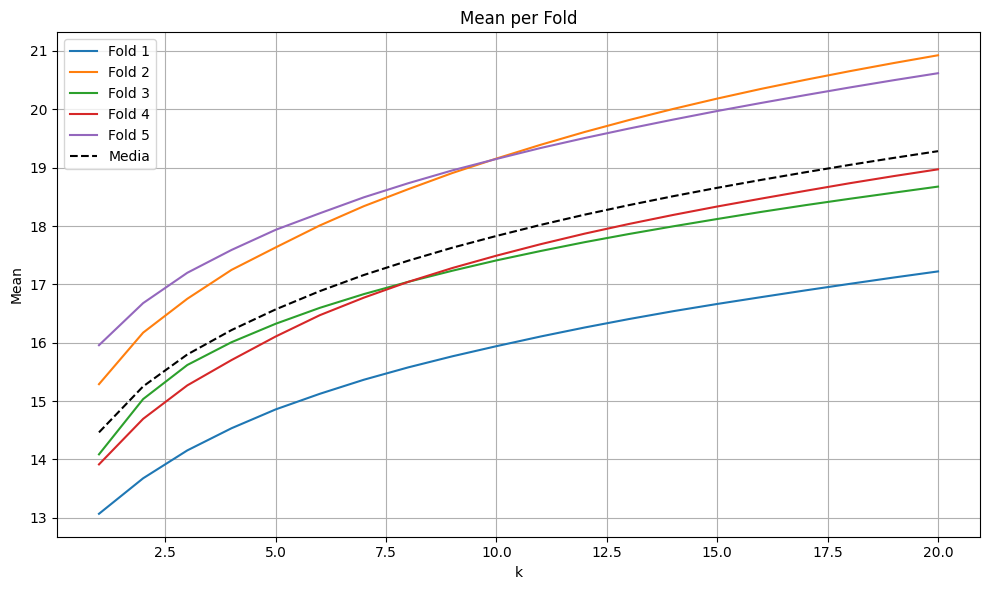

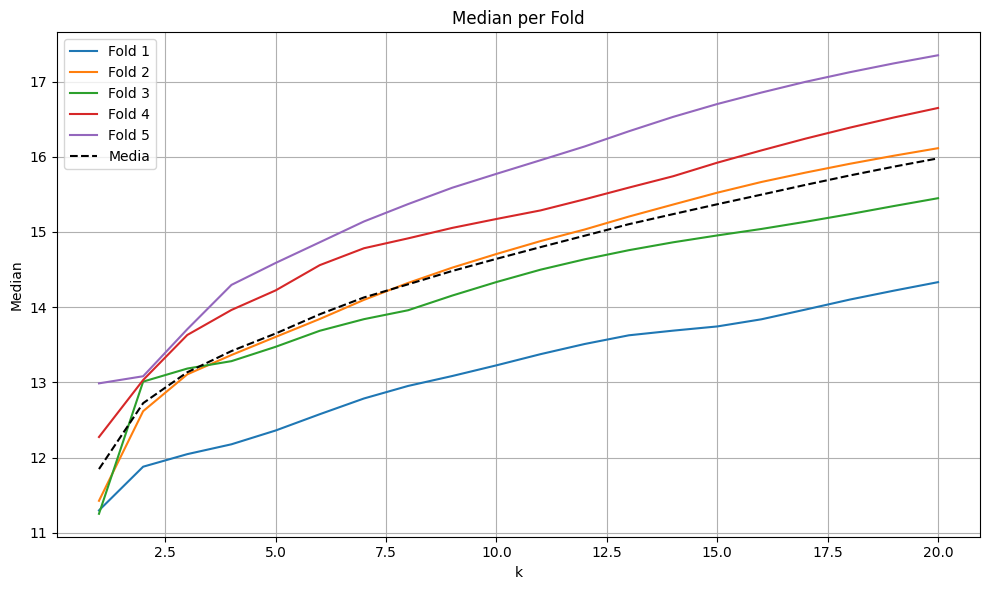

fold,1,2,3,4,5
feature,,,,,
mean,15.365985,18.340424,16.597486,17.041842,18.492214
q25,11.171932,12.153466,10.791387,14.394521,11.989321
q50,12.951825,14.096324,13.009253,14.558239,15.370228
q75,18.200077,15.846912,18.546610,19.073553,19.529625


In [28]:
#################################################### MEAN ########################################
knee_k20_mean_point, knee_k20_mean_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=20,
    nfolds=5,
    aggregation='mean'
)
knee_k20_mean_values


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]



--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]



--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


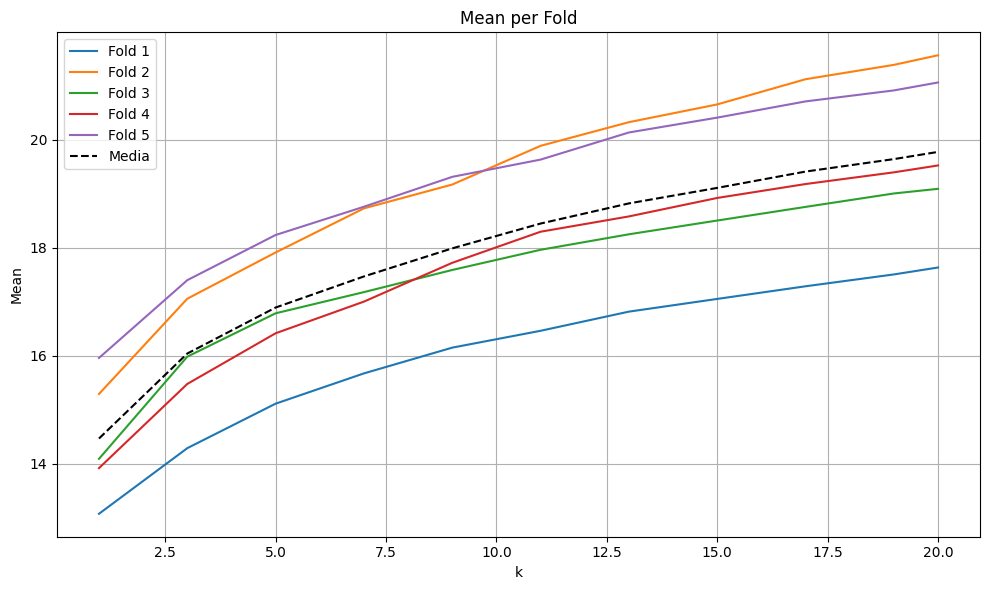

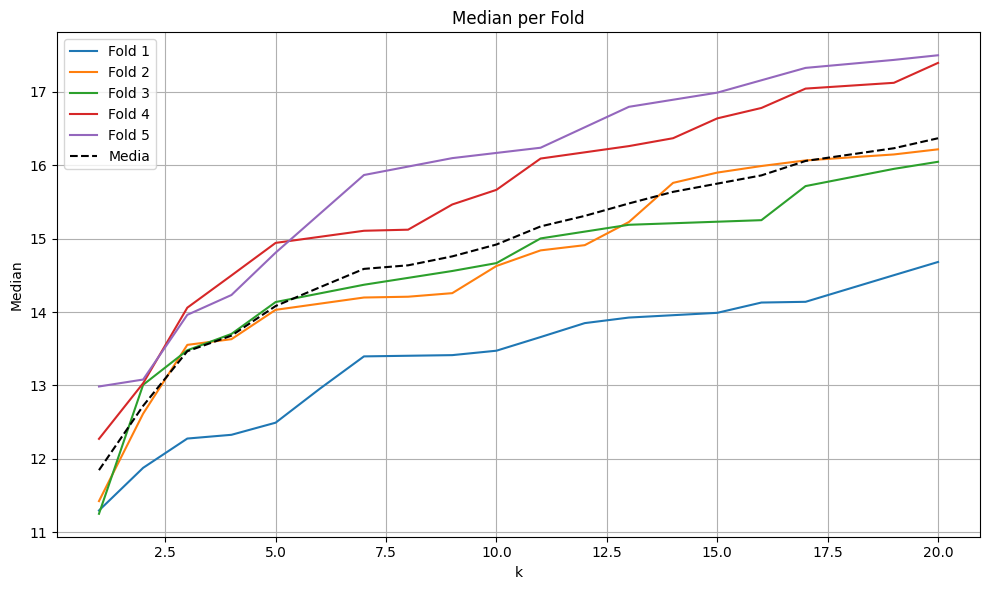

fold,1,2,3,4,5
feature,,,,,
mean,15.671494,19.890801,16.785558,17.721876,19.315518
q25,11.946997,12.427813,11.616810,14.939818,12.116470
q50,13.396233,14.030592,14.136696,14.942678,15.867437
q75,18.361231,17.539066,17.288092,20.554021,18.741325


In [29]:
######################################################### MEDAIN ###########################################
knee_k20_median_point, knee_k20_median_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=20,
    nfolds=5,
    aggregation='median'
)
knee_k20_median_values

## K=50


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]



--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]



--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


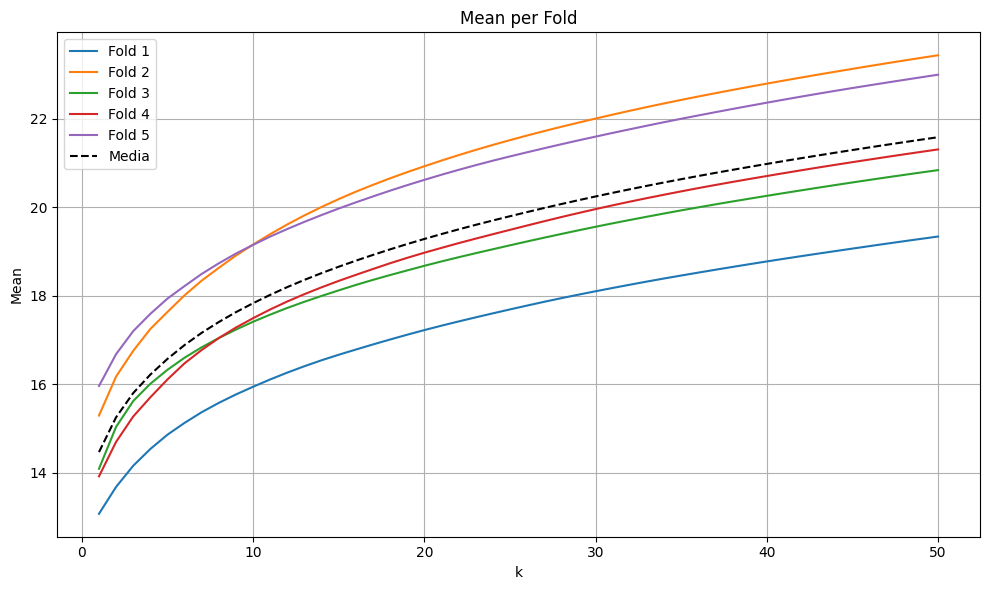

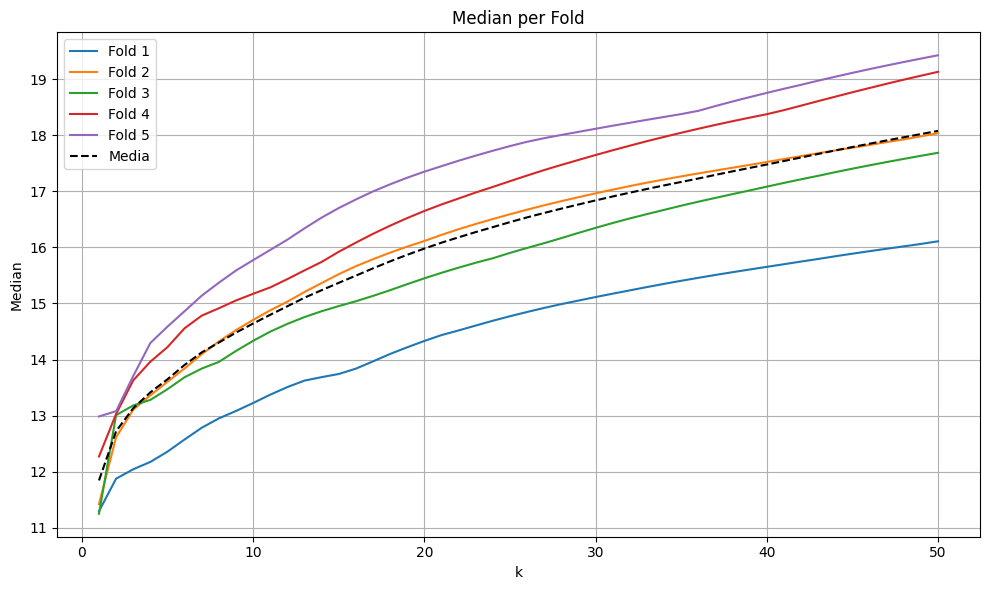

fold,1,2,3,4,5
feature,,,,,
mean,16.539850,20.350771,17.862803,18.189268,19.970613
q25,11.683420,13.031814,11.053257,15.062031,13.783615
q50,14.436068,15.664089,14.636004,16.386395,16.996210
q75,19.280310,19.651419,19.943132,21.585089,20.683069


In [30]:
###################################### MEAN ###################################
knee_k50_mean_point, knee_k50_mean_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=50,
    nfolds=5,
    aggregation='mean'
)
knee_k50_mean_values

In [ ]:
###################################### MEDAIN ##################################
knee_k50_median_point, knee_k50_median_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=50,
    nfolds=5,
    aggregation='median'
)
knee_k50_median_values

## K=100


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]



--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]



--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


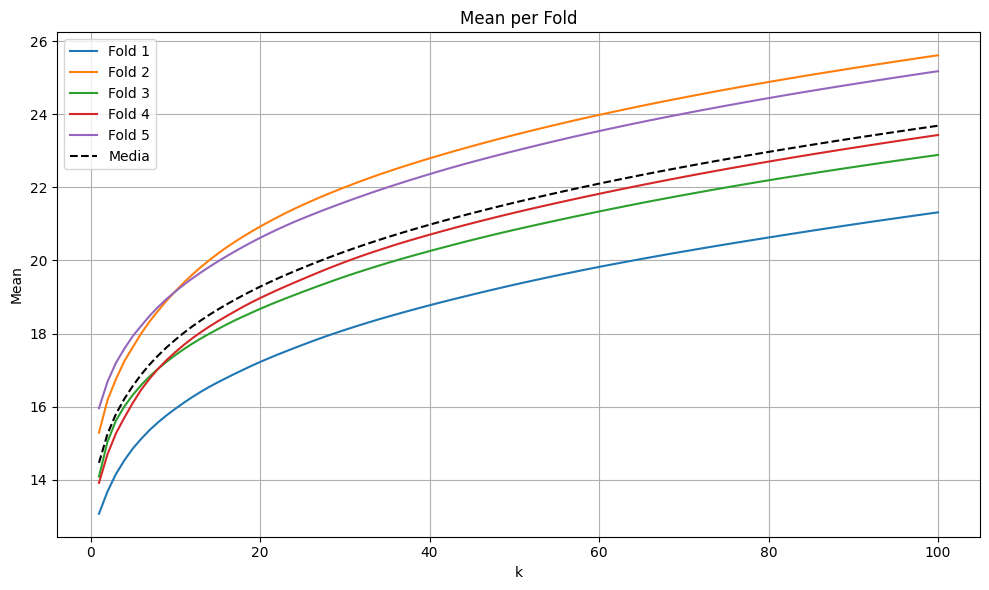

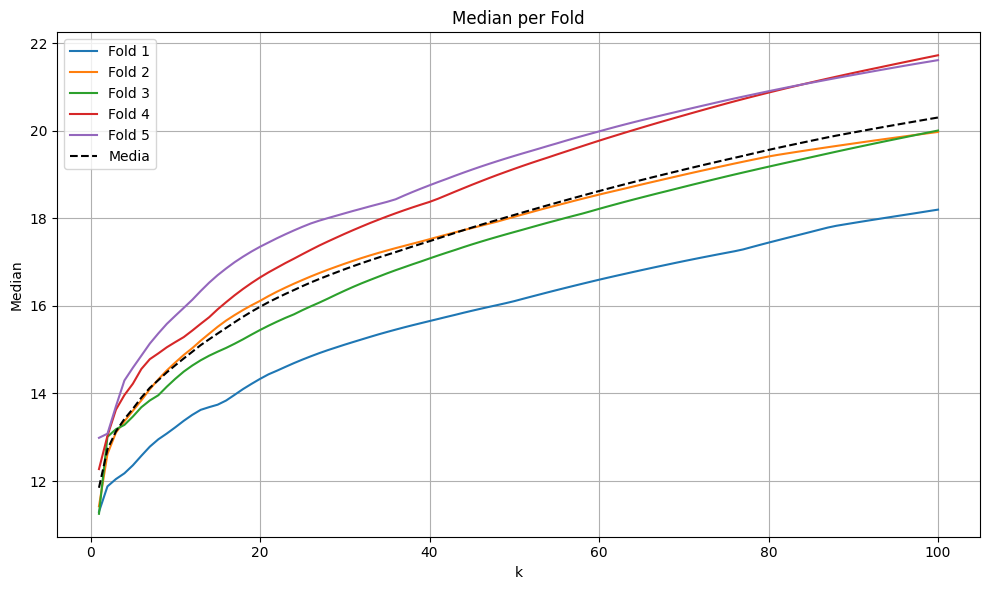

fold,1,2,3,4,5
feature,,,,,
mean,17.861561,21.516457,19.049767,19.682940,21.242065
q25,14.868371,14.123301,12.546450,16.275032,14.808153
q50,14.920898,16.505560,16.347506,17.378284,17.635201
q75,20.051750,20.850571,20.735491,22.919125,21.460506


In [31]:
###################################### MEAN ###################################
knee_k100_mean_point, knee_k100_mean_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=100,
    nfolds=5,
    aggregation='mean'
)
knee_k100_mean_values


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]



--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 100/100 [00:47<00:00,  2.13it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]



--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


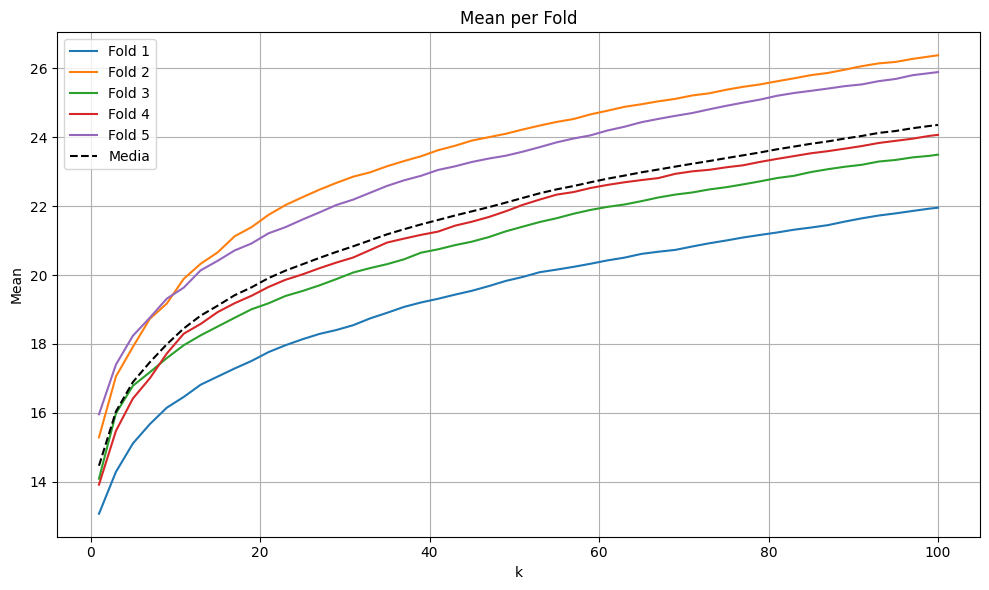

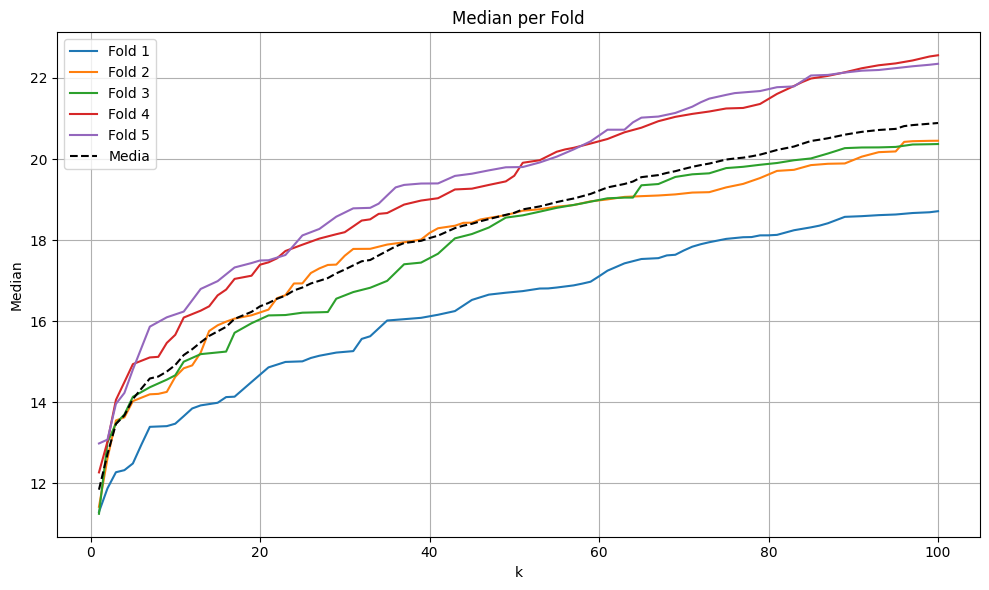

fold,1,2,3,4,5
feature,,,,,
mean,17.961985,22.259659,20.074577,19.862447,22.034169
q25,12.887188,13.372346,12.446249,15.505146,13.055738
q50,13.396233,14.030592,15.189404,14.942678,17.327158
q75,18.361231,17.539066,20.357307,20.554021,22.140625


In [32]:
###################################### MEDAIN ##################################
knee_k100_median_point, knee_k100_median_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=100,
    nfolds=5,
    aggregation='median'
)
knee_k100_median_values

## K=500


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1: 100%|██████████| 500/500 [03:55<00:00,  2.12it/s]



--- Fold 2 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 2: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s]



--- Fold 3 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 3: 100%|██████████| 500/500 [04:13<00:00,  1.97it/s]



--- Fold 4 ---
Positivi: 26 (1.09%)
Negativi: 2355 (98.91%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 4: 100%|██████████| 500/500 [04:14<00:00,  1.97it/s]



--- Fold 5 ---
Positivi: 25 (1.05%)
Negativi: 2355 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 5: 100%|██████████| 500/500 [04:04<00:00,  2.05it/s]


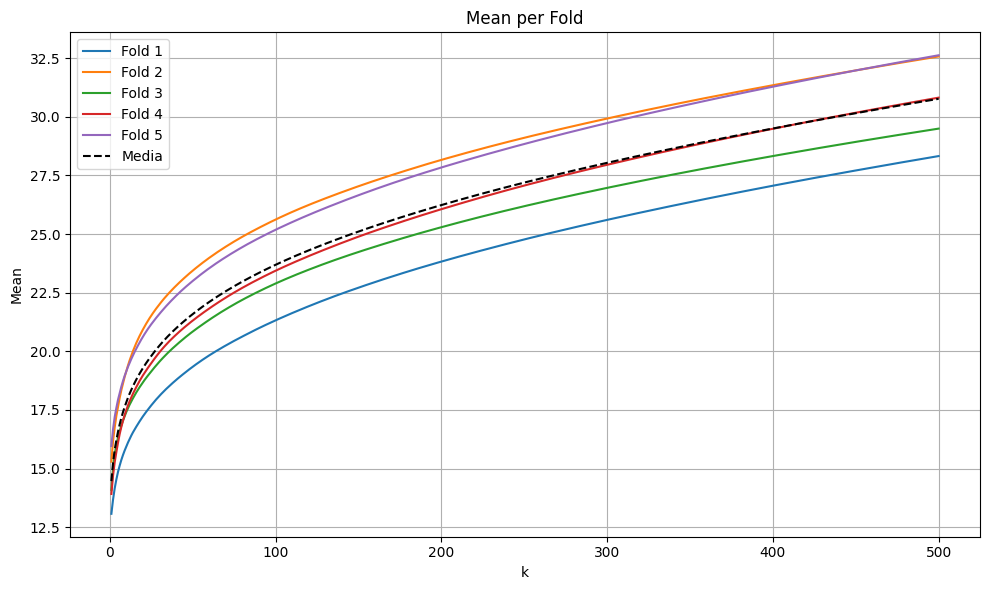

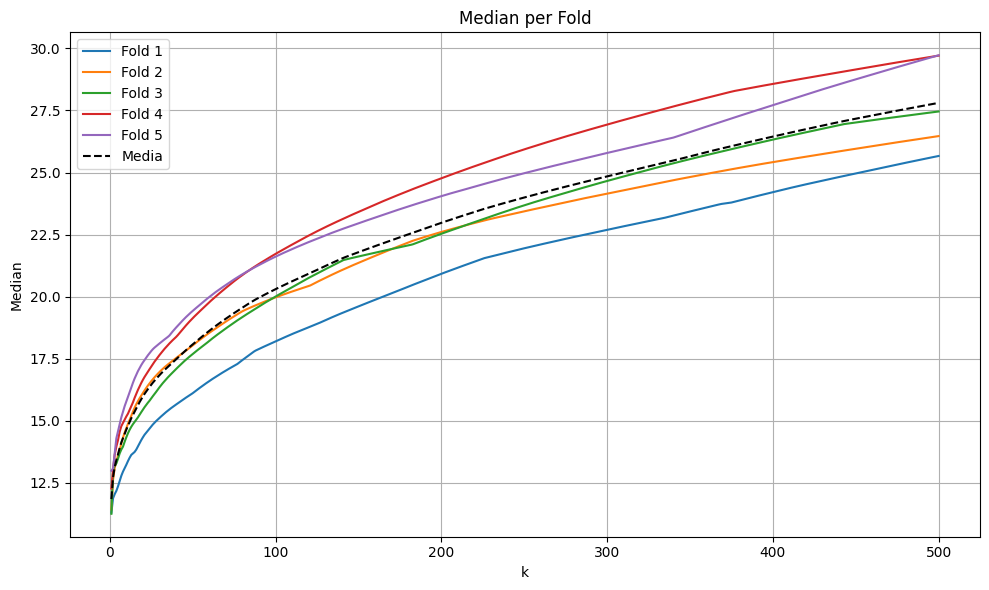

fold,1,2,3,4,5
feature,,,,,
mean,21.537216,25.514284,23.014772,23.400564,25.248192
q25,17.407116,16.802330,17.052210,18.623396,18.217081
q50,19.195295,19.505981,21.474625,22.495028,21.480993
q75,23.772165,24.487843,24.212385,25.857698,24.799053


In [33]:
###################################### MEAN ###################################
knee_k500_mean_point, knee_k500_mean_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=500,
    nfolds=5,
    aggregation='mean'
)
knee_k500_mean_values

In [ ]:
###################################### MEDAIN ##################################
knee_k500_median_point, knee_k500_median_values = run_knee_cv(
    data,
    encoder_name='bert-base-nli-mean-tokens',
    max_k=500,
    nfolds=5,
    aggregation='median'
)
knee_k500_median_values


--- Fold 1 ---
Positivi: 25 (1.05%)
Negativi: 2356 (98.95%)
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


Fold 1:  29%|██▊       | 143/500 [01:06<02:37,  2.26it/s]